# Red densa con PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from torch import nn
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD

np.random.seed(142)
th.manual_seed(142)

## Conjunto de datos

Usaremos el conjunto de datos de regresión Diabetes Dataset que se puede obtener con scikit-learn. Este conjunto de datos está compuesto por 442 ejemplos con 10 atributos numéricos y una variable de respuesta.

In [2]:
db = load_diabetes(return_X_y = False, as_frame=True)
X = db['data'].to_numpy()
y = db['target'].to_numpy()

Dividimos este conjunto en subconjuntos de entrenamiento, validación y prueba usando la función `train_test_split` de scikit-learn.

In [3]:
X_ent, X_prueba, y_ent, y_prueba = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=142)
# se subdivide el conjunto de entrenamiento
X_ent, X_val, y_ent, y_val = train_test_split(X_ent, y_ent, test_size=0.2, shuffle=True, random_state=142)

Estandarizamos los valores de los atributos:

In [4]:
sc = StandardScaler()
sc.fit(X_ent)
X_ent = sc.transform(X_ent)
X_val = sc.transform(X_val)
X_prueba = sc.transform(X_prueba)

Convertimos los subconjuntos de arreglos de NumPy a instancias de Tensor de PyTorch y los cargamos al GPU (si está disponible). Para evitar errores de tipos de datos distintos de los operandos, es importante asegurarse de que coincidan. En esta libreta vamos a trabajar con enteros de 32 bits, por lo que lo especificamos en la función `tensor`.

In [5]:
disp = 'cuda:0' if th.cuda.is_available() else 'cpu'
X_ent = th.tensor(X_ent, dtype = th.float32, device = disp)
X_val = th.tensor(X_val, dtype = th.float32, device = disp)
X_prueba = th.tensor(X_prueba, dtype = th.float32, device = disp)

y_ent = th.tensor(y_ent, dtype = th.float32, device = disp)
y_val = th.tensor(y_val, dtype = th.float32, device = disp)
y_prueba = th.tensor(y_prueba, dtype = th.float32, device = disp)

También es importante asegurarse de que las formas de los tensores de las predicciones (`y_hat`) y de las salidas reales (`y`) sean iguales. Aquí vamos a presuponer que son vectores columna de $n \times 1$, por lo que cambiamos de forma.

In [6]:
y_ent = y_ent.reshape((y_ent.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_prueba = y_prueba.reshape((y_prueba.shape[0], 1))

Creamos nuestro cargador de datos a partir de los tensores mediante la clase `TensorDataset`.

In [7]:
entdl = DataLoader(TensorDataset(X_ent, y_ent), batch_size=16, shuffle=True, drop_last=True)
valdl = DataLoader(TensorDataset(X_val, y_val), batch_size=16, shuffle=False, drop_last=False)
pruebadl = DataLoader(TensorDataset(X_prueba, y_prueba), batch_size=1, shuffle=False, drop_last=False)

In [8]:
def paso_ent(modelo, fp, opt, X, y):
    opt.zero_grad() # se ponen los gradientes asociados a los parámetros a actualizar en 0
    y_hat = modelo(X)
    perdida = fp(y_hat, y)
    perdida.backward()
    opt.step()

    with th.no_grad():
        perdida_paso = perdida.cpu().numpy() # convertimos la perdida (instancia de
                                             # Tensor de orden 0) a NumPy, para lo que es
                                             # necesario moverla a CPU
    return perdida_paso

In [9]:
def entrena(modelo, fp, metrica, opt, entdl, valdl, n_epocas=100):
    hist = {'perdida_ent':np.zeros(n_epocas, dtype=np.float32), 'perdida_val':np.zeros(n_epocas, dtype=np.float32)}
    for e in range(n_epocas):
        # bucle de entrenamiento
        modelo.train()
        for lote, (Xlote, ylote) in enumerate(entdl):
            hist['perdida_ent'][e] += paso_ent(modelo, fp, opt, Xlote, ylote)
        # bucle de evaluación
        modelo.eval()
        for (Xlote, ylote) in valdl:
            with th.no_grad():
                y_pred = modelo(Xlote)
                hist['perdida_val'][e] += metrica(y_pred, ylote).cpu().numpy()
    return hist

## 1. Aumento de número de capas ocultas

Tomando la red neuronal creada con Sequential, se va a comparar la de dos capas ocultas con una de 6 capas ocultas.

### Dos capas ocultas.

In [14]:
modelo_2c = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                       nn.Sigmoid(),
                       nn.Linear(10,20),
                       nn.Sigmoid(),
                       nn.Linear(20,1))

Movemos nuestra red a la GPU, creamos el criterio de ECM, instanciamos el optimizador, entrenamos y graficamos la pérdida.

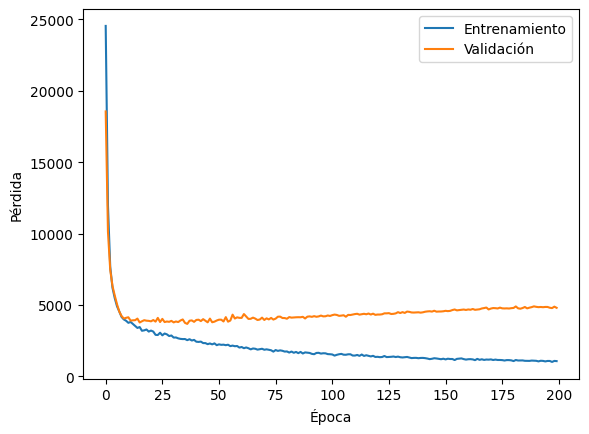

In [11]:
modelo_2c.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo_2c.parameters(), lr=1e-3)
hist = entrena(modelo_2c, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### Seis capas ocultas

In [12]:
modelo_6c = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                       nn.Sigmoid(),
                       nn.Linear(10,20),
                       nn.Sigmoid(),
                       nn.Linear(20,20),
                       nn.Sigmoid(),
                       nn.Linear(20,20),
                       nn.Sigmoid(),
                       nn.Linear(20,1))

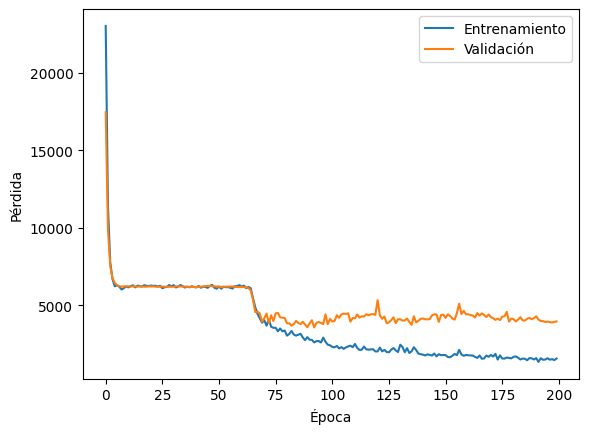

In [13]:
modelo_6c.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo_6c.parameters(), lr=1e-3)
hist = entrena(modelo_6c, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## 2. Cambio de funciones de activación

Se toma la red de dos capas ocultas y se cambian las funciones sigmoide por ReLU.

In [18]:
modelo_fa = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                       nn.ReLU(),
                       nn.Linear(10,20),
                       nn.ReLU(),
                       nn.Linear(20,1))

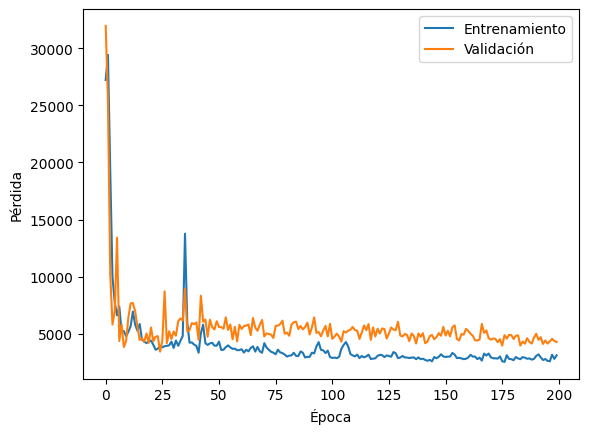

In [16]:
modelo_fa.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo_fa.parameters(), lr=1e-3)
hist = entrena(modelo_fa, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## 3. Regularización

Se utilizará Dropout (desactivación de neuronas) para regularizar una red neuronal.

In [21]:
modelo_do = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                       nn.Sigmoid(),
                       nn.Dropout(p=0.5),
                       nn.Linear(10,20),
                       nn.Dropout(p=0.5),
                       nn.Sigmoid(),
                       nn.Dropout(p=0.5),
                       nn.Linear(20,1))

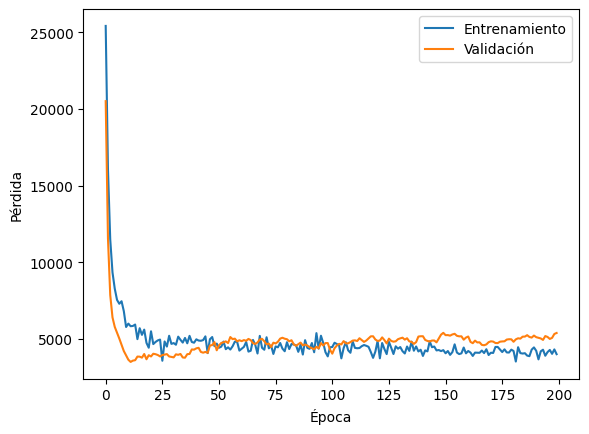

In [22]:
modelo_do.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo_do.parameters(), lr=1e-3)
hist = entrena(modelo_do, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## 4. Capas de normalización

Se aplicará batch normalization a la red neuronal de dos capas ocultas.

In [24]:
modelo_bn = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                          nn.Sigmoid(),
                          nn.BatchNorm1d(10),
                          nn.Linear(10,20),
                          nn.BatchNorm1d(20),
                          nn.Sigmoid(),
                          nn.BatchNorm1d(20),
                          nn.Linear(20,1))

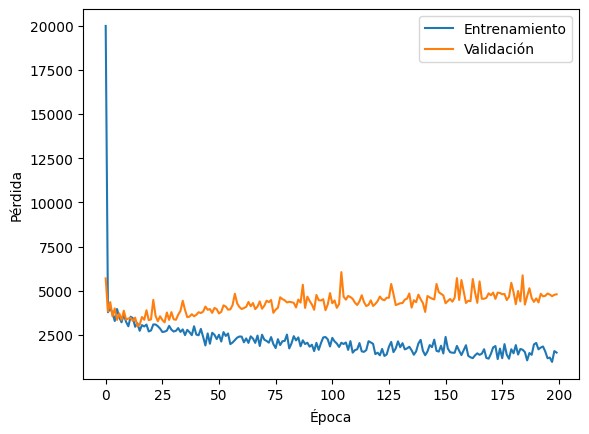

In [25]:
modelo_bn.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo_bn.parameters(), lr=1e-3)
hist = entrena(modelo_bn, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()